# Hydraulijärjestelmän mallien analyysi ja visualisointi

Tässä notebookissa analysoidaan ja visualisoidaan hydraulijärjestelmän tilan luokitteluun käytettäviä koneoppimismalleja. Notebook yhdistää toiminnallisuuden modelAnalysis.py ja modelVisualizer.py -tiedostoista.

## Kirjastojen lataus

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import joblib
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.model_selection import learning_curve
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

## Mallien lataus

Ladataan tallennetut mallit (SVM, Random Forest, XGBoost) ja skaalauskomponentti.

In [2]:
def loadModels():
    """
    Lataa tallennetut mallit ja skaalauskomponentti
    """
    print("Ladataan mallit...")
    currentDir = os.path.dirname(os.path.abspath("__file__"))
    modelsDir = os.path.join(os.path.dirname(currentDir), 'Models')
    
    # Lataa mallit
    svmModel = pickle.load(open(os.path.join(modelsDir, 'SVM.pkl'), 'rb'))
    rfModel = pickle.load(open(os.path.join(modelsDir, 'RandomForest.pkl'), 'rb'))
    xgbModel = pickle.load(open(os.path.join(modelsDir, 'XGBoost.pkl'), 'rb'))
    
    # Muokkaa SVM-mallia niin, että se tukee predict_proba-metodia
    if hasattr(svmModel, 'probability') and not svmModel.probability:
        print("Huomautus: SVM-malli ei tue todennäköisyysennusteita. Joitakin visualisointeja ei voida luoda.")
    
    # Lataa skaalauskomponentti
    scaler = joblib.load(os.path.join(modelsDir, 'hydraulicScaler.joblib'))
    
    return svmModel, rfModel, xgbModel, scaler

# Ladataan mallit
svmModel, rfModel, xgbModel, scaler = loadModels()
models = [svmModel, rfModel, xgbModel]

Ladataan mallit...
Huomautus: SVM-malli ei tue todennäköisyysennusteita. Joitakin visualisointeja ei voida luoda.


## Testidatan lataus

Ladataan testdata analyysiä ja visualisointia varten.

In [3]:
def loadData():
    """
    Lataa testdata analyysiä varten
    """
    print("Ladataan testdata...")
    currentDir = os.path.dirname(os.path.abspath("__file__"))
    dataDir = os.path.join(os.path.dirname(currentDir), 'Data')
    
    # Lataa testdata
    testData = pd.read_csv(os.path.join(dataDir, 'testData.csv'))
    
    # Erota syöte- ja kohdemuuttujat
    xTest = testData[['pumpControl', 'pressure']]
    yTest = testData['state']
    
    # Muunna luokat numeerisiksi
    labelEncoder = LabelEncoder()
    yTestEncoded = labelEncoder.fit_transform(yTest)
    
    # Palauta luokkien nimet
    classNames = labelEncoder.classes_
    
    return xTest, yTest, yTestEncoded, classNames, labelEncoder

# Ladataan testdata
xTest, yTest, yTestEncoded, classNames, labelEncoder = loadData()
print(f"Testidatan koko: {xTest.shape[0]} riviä")
print(f"Luokat: {classNames.tolist()}")

Ladataan testdata...
Testidatan koko: 1489 riviä
Luokat: ['hose_break', 'normal_digging', 'normal_empty', 'normal_full', 'overload']


## Päätösrajapintojen visualisointi

Luodaan päätösrajapintakuvaaja jokaiselle mallille (SVM, Random Forest, XGBoost).

Käytetään olemassa olevaa Visualization-kansiota: d:\Rakentelu\Projektit\10_LED_ohjain_2313_baremetal_ML\HydraulicControlML\Visualization
Luodaan päätösrajapintakuvaajat...


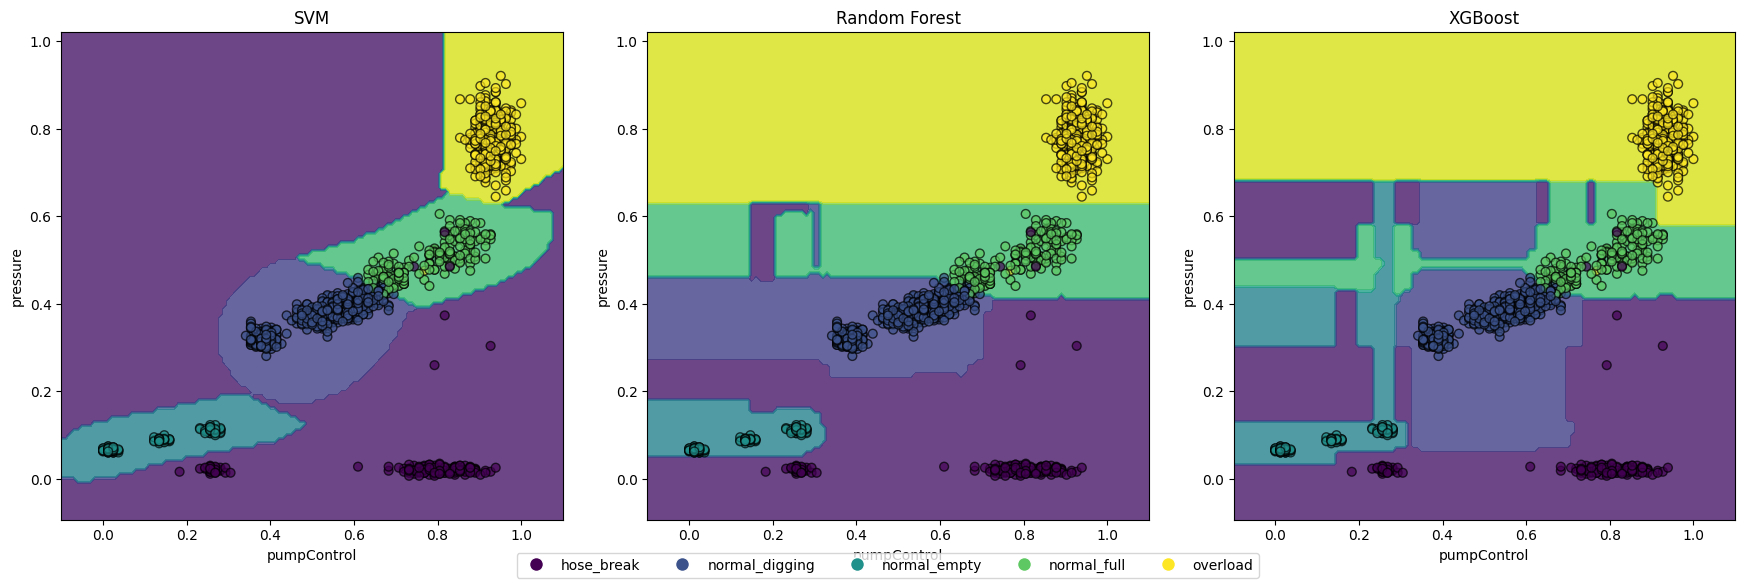

Päätösrajapintakuvaaja tallennettu: d:\Rakentelu\Projektit\10_LED_ohjain_2313_baremetal_ML\HydraulicControlML\Visualization\decisionBoundaries.png


In [5]:
# Määritellään visualizationDir
currentDir = os.path.dirname(os.path.abspath("__file__"))
projectRoot = os.path.dirname(currentDir)
visualizationDir = os.path.join(projectRoot, 'Visualization')
print(f"Käytetään olemassa olevaa Visualization-kansiota: {visualizationDir}")

def createDecisionBoundaryPlot(models, xTest, yTestEncoded, classNames, scaler):
    """
    Luo päätösrajapintakuvaaja jokaiselle mallille
    """
    print("Luodaan päätösrajapintakuvaajat...")
    
    # Luo kuvaaja
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    plt.tight_layout(pad=3.0)
    
    # Mallit ja niiden nimet
    modelNames = ['SVM', 'Random Forest', 'XGBoost']
    
    # Määritä kuvaajan rajat
    pumpMin, pumpMax = xTest['pumpControl'].min() - 0.1, xTest['pumpControl'].max() + 0.1
    pressureMin, pressureMax = xTest['pressure'].min() - 0.1, xTest['pressure'].max() + 0.1
    
    # Luo ruudukko
    xx, yy = np.meshgrid(np.arange(pumpMin, pumpMax, 0.01),
                         np.arange(pressureMin, pressureMax, 0.01))
    
    # Värikartta luokille
    cmap = plt.colormaps['viridis']
    
    # Piirrä päätösrajapinta jokaiselle mallille
    for i, (model, name) in enumerate(zip(models, modelNames)):
        # Ennusta ruudukolla
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        # Varmista että nimet ovat oikein
        grid_points_df = pd.DataFrame(grid_points, columns=['pumpControl', 'pressure'])
        Z = model.predict(grid_points_df)
        Z = Z.reshape(xx.shape)
        
        # Piirrä päätösrajapinta
        axes[i].contourf(xx, yy, Z, alpha=0.8, cmap=cmap)
        
        # Piirrä testipisteet
        scatter = axes[i].scatter(xTest['pumpControl'], xTest['pressure'], c=yTestEncoded, 
                    cmap=cmap, edgecolors='k', s=40, alpha=0.7)
        
        axes[i].set_title(name)
        axes[i].set_xlabel('pumpControl')
        axes[i].set_ylabel('pressure')
        axes[i].set_xlim(pumpMin, pumpMax)
        axes[i].set_ylim(pressureMin, pressureMax)
    
    # Lisää yhteinen selite
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i/(len(classNames)-1)), 
                         markersize=10) for i in range(len(classNames))]
    fig.legend(handles, classNames, loc="lower center", ncol=len(classNames), bbox_to_anchor=(0.5, 0))
    
    # Tallenna kuvaaja
    plt.savefig(os.path.join(visualizationDir, 'decisionBoundaries.png'),
               bbox_inches='tight')
    plt.show()
    plt.close()
    
    print(f"Päätösrajapintakuvaaja tallennettu: {os.path.join(visualizationDir, 'decisionBoundaries.png')}")

# Luodaan päätösrajapintakuvaaja
createDecisionBoundaryPlot(models, xTest, yTestEncoded, classNames, scaler)

## Sekaannusmatriisien visualisointi

Luodaan sekaannusmatriisi jokaiselle mallille.

Luodaan sekaannusmatriisit...


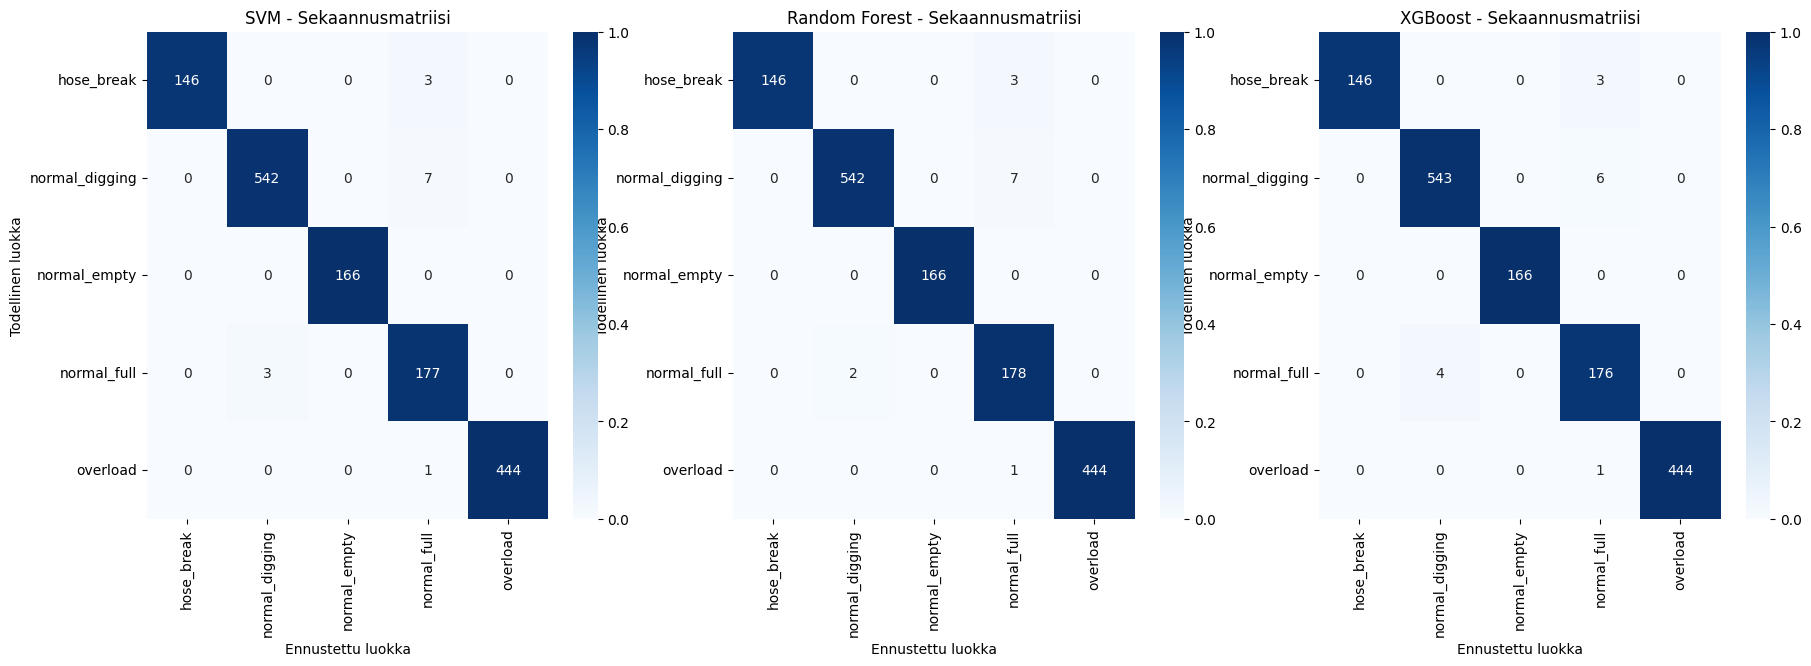

Sekaannusmatriisit tallennettu: d:\Rakentelu\Projektit\10_LED_ohjain_2313_baremetal_ML\HydraulicControlML\Visualization\confusionMatrices.png


In [6]:
def createConfusionMatrix(models, xTest, yTestEncoded, classNames):
    """
    Luo sekaannusmatriisi jokaiselle mallille
    """
    print("Luodaan sekaannusmatriisit...")
    
    # Luo kuvaaja
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    plt.tight_layout(pad=3.0)
    
    # Mallit ja niiden nimet
    modelNames = ['SVM', 'Random Forest', 'XGBoost']
    
    # Piirrä sekaannusmatriisi jokaiselle mallille
    for i, (model, name) in enumerate(zip(models, modelNames)):
        # Ennusta testidatalla
        predictions = model.predict(xTest)
        
        # Laske sekaannusmatriisi
        cm = confusion_matrix(yTestEncoded, predictions)
        
        # Normalisoi sekaannusmatriisi
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # Piirrä sekaannusmatriisi
        sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', ax=axes[i],
                   xticklabels=classNames, yticklabels=classNames)
        
        axes[i].set_title(f"{name} - Sekaannusmatriisi")
        axes[i].set_xlabel('Ennustettu luokka')
        axes[i].set_ylabel('Todellinen luokka')
    
    # Tallenna kuvaaja
    plt.savefig(os.path.join(visualizationDir, 'confusionMatrices.png'),
               bbox_inches='tight')
    plt.show()
    plt.close()
    
    print(f"Sekaannusmatriisit tallennettu: {os.path.join(visualizationDir, 'confusionMatrices.png')}")

# Luodaan sekaannusmatriisit
createConfusionMatrix(models, xTest, yTestEncoded, classNames)

## Piirteiden tärkeyden visualisointi

Luodaan piirteiden tärkeysvertailu Random Forest ja XGBoost -malleille.

Luodaan piirteiden tärkeysvertailu...


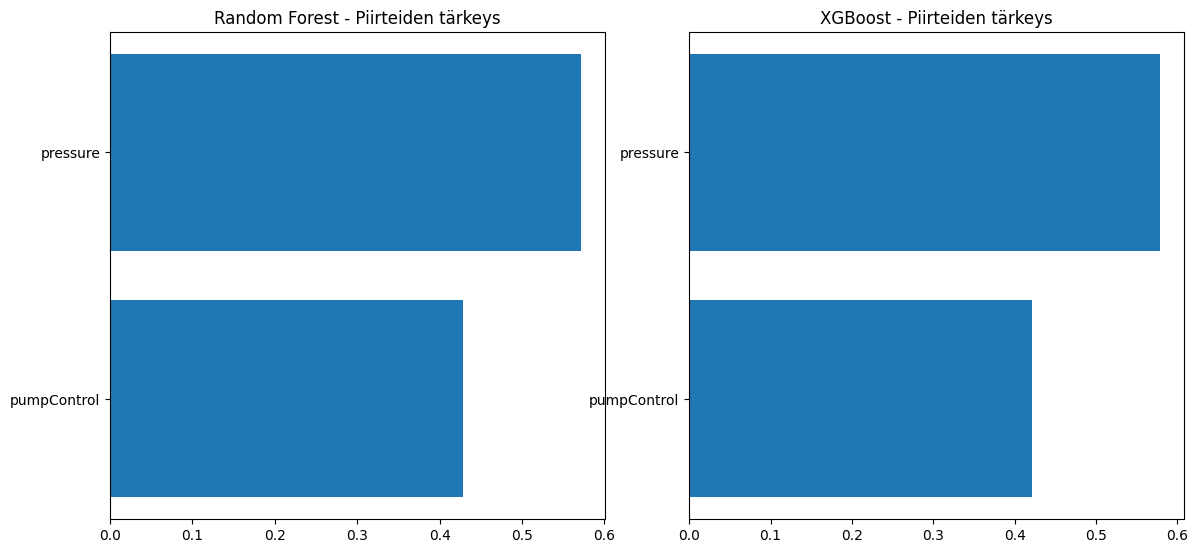

Piirteiden tärkeysvertailu tallennettu: d:\Rakentelu\Projektit\10_LED_ohjain_2313_baremetal_ML\HydraulicControlML\Visualization\featureImportance.png


In [7]:
def createFeatureImportancePlot(models, featureNames):
    """
    Luo piirteiden tärkeysvertailu Random Forest ja XGBoost -malleille
    """
    print("Luodaan piirteiden tärkeysvertailu...")
    
    # Luo kuvaaja
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    plt.tight_layout(pad=3.0)
    
    # Random Forest
    if hasattr(models[1], 'feature_importances_'):
        rfImportances = models[1].feature_importances_
        indices = np.argsort(rfImportances)
        
        axes[0].barh(range(len(indices)), rfImportances[indices], align='center')
        axes[0].set_yticks(range(len(indices)))
        axes[0].set_yticklabels([featureNames[i] for i in indices])
        axes[0].set_title('Random Forest - Piirteiden tärkeys')
    else:
        axes[0].text(0.5, 0.5, "Piirteiden tärkeys ei saatavilla", ha='center', va='center')
    
    # XGBoost
    if hasattr(models[2], 'feature_importances_'):
        xgbImportances = models[2].feature_importances_
        indices = np.argsort(xgbImportances)
        
        axes[1].barh(range(len(indices)), xgbImportances[indices], align='center')
        axes[1].set_yticks(range(len(indices)))
        axes[1].set_yticklabels([featureNames[i] for i in indices])
        axes[1].set_title('XGBoost - Piirteiden tärkeys')
    else:
        axes[1].text(0.5, 0.5, "Piirteiden tärkeys ei saatavilla", ha='center', va='center')
    
    # Tallenna kuvaaja
    plt.savefig(os.path.join(visualizationDir, 'featureImportance.png'),
               bbox_inches='tight')
    plt.show()
    plt.close()
    
    print(f"Piirteiden tärkeysvertailu tallennettu: {os.path.join(visualizationDir, 'featureImportance.png')}")

# Luodaan piirteiden tärkeysvertailu
featureNames = ['pumpControl', 'pressure']
createFeatureImportancePlot(models, featureNames)